In [18]:
%run ./"0 Imports and functions.ipynb"
import pickle 
%matplotlib widget

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
spectral_cube 0.6.1.dev22+g003ef16
spectral_cube file path /home/ben/.local/lib/python3.8/site-packages/spectral_cube/__init__.py
reproject 0.8
3.3.4 Matplotlib
/home/ben/miniconda3/lib/python3.8/site-packages/matplotlib/__init__.py
1.23.1 Numpy
astrodendro_file: /home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py
Results will be saved to Directory ./Result Files
Cubes will be saved and loaded with Directory ./Spectral Cubes
Plots will be saved to Directory ./Plots
Dendrograms will be saved to Directory ./Dendrograms


# Figure 2


The continuum has unit Jy / beam
Change to: Jy / beam
verify unit length is non zero, length =  9 Jy / beam
0.33 K   RMS Noise for NGC_253_HCN_J1-0_
(13.33, 8)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
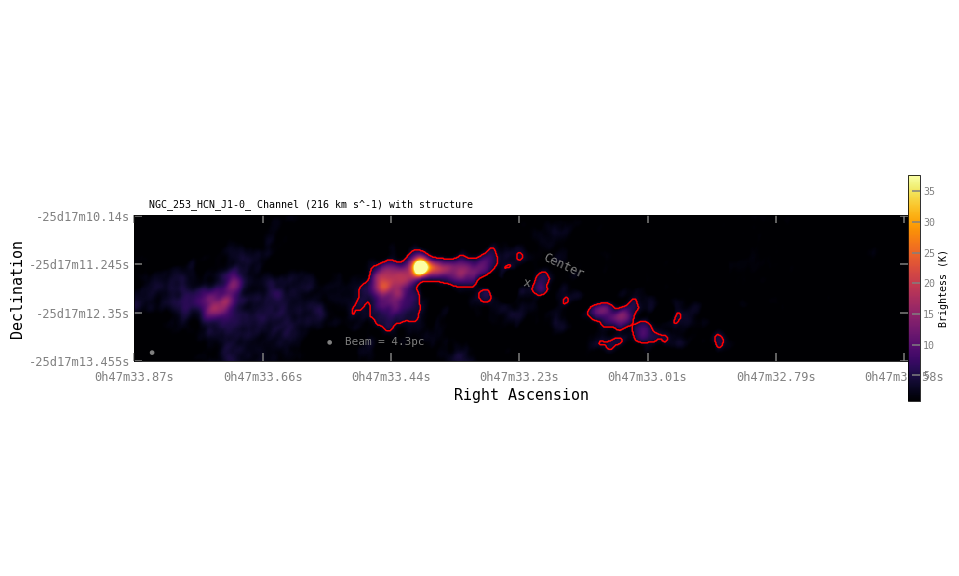

In [44]:
#testing cmz=coutours with lower vel range


"""CO 1-0 CMZ:
                        image_args={"FIX_AXIS":True,
                                   "FIGSIZE": (50,5),
                                   "COLORBARSCALE":.15,
                                   "SCALE":1,
                                   "XLABELS_NUM":58,
                                   "VMAX":550,
                                   "VMIN":-100,
                                   "SHOW":True,
                                   "DPI":800
                                  }
"""
        
image_args={
                                   "SCALE":1,
                                    "ChannelMapWidth": 25*u.km/u.s,
                                    "ChannelMapFIGSIZE": (40,20),
                                    "COLORBARSCALE":1.5,
                                    "XLABELS_NUM":6,
                                    "YLABELS_NUM":3
                                  }
dpi=600
fd = "NGC_253_HCN_J1-0_" # This changes between files based on the line description

with open("Spectral Cubes/Cube Information/"+fd+"_Cube_Information", 'rb') as file:

    Total = [ pickle.load(file)]
    
for Cube_Information in Total:
    
    Line_Name = Cube_Information['File_Descriptor']
    File_Name = Cube_Information['File_Name']
    distance = Cube_Information['distance']
    vel_prime = Cube_Information['velocity_scale']
    center = Cube_Information['center']
    Prime_Beam = (Cube_Information['beam_minor'].to(u.rad)*distance / u.rad).to(u.pc) #The current beam size in pc
    pathCont = Cube_Information["Corresponding_Continuum"]
    beam_area_ratio = Cube_Information['beam_area_ratio']
    
    noise_requirement = Cube_Information["Dendrogram_Noise_Threshold"]
    Minimum_Pixel_Requirement= Cube_Information["Minimum_Pixel_Requirement"] 
    min_delta=Cube_Information["min_delta"] 
    ###
    # Load statistics
    ###
    
    #with open("Result Files/"+"cmz_CO_J3_2_Testing_No_RepeatsCropped_3.0pc_beam_cmz_CO_J3_2_140.0x700.0pc_reprojected_2.5_vel_res__Results", 'rb') as file:
    with open("Result Files/"+fd+File_Name[0:len(File_Name)-5]+"_Results", 'rb') as file:
        Results = pickle.load(file)
        _1,_2,_3,_4,_5,idx,_7,_8,_9 = Results
    
    ###### 
    ### Make plots and contours
    ######
    
    Dend_Name= Cube_Information["Corresponding_Dendrogram"]
    Dendrogram = astrodendro.Dendrogram.load_from('Dendrograms/'+Dend_Name)

    # Load The SC
    
    Qp = SpectralCube.read("Spectral Cubes/"+File_Name).with_spectral_unit(u.km/u.s,velocity_convention="radio")
    Qp.allow_huge_operations=True

    Q = Qp.to(u.K)# Jy to Kelvin in case its not already in
    sc = Q.unmasked_copy() # remove a mask if there is one 
    del Q 
    del Qp

    # The cube data

    scW = sc.wcs[:][:][0]
    datn = sc.hdu.data
    moment_0_sc  = sc.moment(order=0,how='slice')            # Calculate the Moment 0 map to use for plotting
    header = sc.hdu.header
    
    #####
    #####
    # Reproject Continuum image to match the current image (this doesnt require any other data reduction steps since we already did those to the current SC)
    #####
    #####
    
    # Continuum image, for use in the column density maps
    
    scCont = spectral_cube.Projection.from_hdu(fits.open("Spectral Cubes/"+pathCont)) # {Why was there a  [0] here?}
    
    try:
        BUNIT = scCont.unit
        print("The continuum has unit",BUNIT)
        scCont = scCont.to(u.Jy/u.beam) #Fails if unitless
        BUNIT = scCont.unit
        print("Change to:",BUNIT)
        print("verify unit length is non zero, length = ",len(str(BUNIT)),str(BUNIT)) #Fails if there is no unit

    except:
        print("The continuum is unitless; unit defaults to Jy/beam")
        scCont = scCont*u.Jy/u.beam #Some data was taken before BUNIT were implemented, but they are in Jy/beam
        
    Use_Dict = {'desired_beam_oversampling': "NA"} # this is irrelevant since the continuum is higher resolution than the data cubes
    Use_Dict["distance"] = distance # same as for the data cube
    
    Continuum_Information = Update_Cube_Information(Use_Dict,pathCont)
    
    
    ## Reproject continuum 
    scCont.allow_huge_operations=True
    Continuum = scCont.reproject(moment_0_sc.header)
    del scCont
    Continuum_Data  = Continuum.hdu.data
    Cont_Save_File=(Continuum_Information["File_Name"][0:len(Continuum_Information["File_Name"])-5]+"_Reproject_to_"+Cube_Information['File_Descriptor']+".fits")
    
    # save the reprojected continuum     
    Continuum_Information = Update_Cube_Information(Continuum_Information,Cont_Save_File)
    
    # calculate the flux based on the beam to find te column density
    # flux = Jansky/beam/(pixels/beam)/(beam_physical_size in pc^2)*particle number density (using a factor to account for the other, non H2 particles in the 850um continuum)
    pc_per_pixel_continuum = Cube_Information['spatial_scale_y']

    # The flux, converting from Jy/beam, accounting for the beams physical size
    flux = (Continuum_Data*Continuum[0][0].unit)/((Continuum_Information["beam_area_ratio"]*(pc_per_pixel_continuum**2)).to(u.cm**2/u.beam))
    
    Column_Densities = Flux_to_Mass(flux,distance)*Num_per_kg  # Calculates the number-luminosity from the particle flux and converts it to mass using the conversion factor from Bolatto 2013a, in number/cm^2
    
    # Ratio of flux / column density (compare the continuum to teh line emission)
    rm=moment_0_sc.hdu.data/Column_Densities
    rmU = rm*moment_0_sc[0][0].unit # Just put the units back in
    del rm
    
    #rmU = np.array(rmU/10**22,dtype='float64')# reduce to floating point scale because they cant handle nubers this big

    ###### there are errors at low points, giving negative mass, so i exclude them if theyre below the noise

    bp = np.where(Column_Densities<=7*10**22/u.cm**2)
    bp2 = np.where(moment_0_sc.hdu.data < (np.nanstd(moment_0_sc.hdu.data,where= ((moment_0_sc.hdu.data>0)  | (moment_0_sc.hdu.data<0) )))) # below the Noise (K km/s)
    Continuum_Data_Cropped = copy.deepcopy(Continuum_Data)
    Continuum_Data_Cropped[bp] = np.nan # A version of the continuum data withuot the negative pixels
    
    Column_Densities_Cropped = copy.deepcopy(Column_Densities)
    Column_Densities_Cropped[bp]=np.nan # Remove negative pixels from the column densities
    
    rmU[bp]=np.nan # Remove the negative pixels from either the moment 0 or the continuum
    rmU[bp2]=np.nan

    #######

    m=Cube_Information["RMS_Noise"]
    
    print(m,"  RMS Noise for",Cube_Information["File_Descriptor"])
    
 





    ######
    ######
    ######
    ### Generate relevant plots before the dendrogram so we know what we're looking at
    ######
    ######
    ######
        
    #def Make_Image_Plot(Title,Cube,vmin,vmax,rows=1,columns=1,index=1,show=False):

    ###### Moment 0 and continuum plots


    #Make_Image_Plot((Line_Name+" Moment 0"),"Moment 0 Intensity (K km s^-1)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=0,vmax=np.nanmax(moment_0_sc.hdu.data),rows=1,columns=1,index=1,show=False,Cube_Info=Cube_Information,image_args=image_args)
    
    #pylab.show()
    '''
    Make_Image_Plot((Line_Name+" Moment 0 PC"),"Moment 0 Intensity (K km s^-1)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=0,vmax=np.nanmax(moment_0_sc.hdu.data),rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information,image_args=image_args)
    
    Center_p = moment_0_sc.wcs.world_to_pixel(center)
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()

    
    
    
    Make_Image_Plot((Line_Name+"Column Density"),"Column Density (# cm^-2)",Column_Densities,wcs=moment_0_sc.wcs,vmin=float(np.nanmin(Column_Densities.value)),vmax=float(np.nanmax(Column_Densities.value)),rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information) # Use the full line SC information here becasue I dont need specific things
    
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()


    Make_Image_Plot((Line_Name+" Moment 0 over Column Density of the Continuum"), "Ratio (K km s^-1 over (# cm^-2))",rmU.value,wcs=moment_0_sc.wcs,vmin=np.nanmean(rmU.value)*.5,vmax=abs(np.nanmean(rmU.value))*8,rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information)
    
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()

    '''  
    
    #def make_channel_maps(Title,Units,Cube_data,wcs,vmin,vmax,Axis="RADEC",Cube_Info='nil',image_args={},figsize=(13.33,8),numx=5,numy=5):

    moment_0_sc = sc[64]
    fig, ax ,im,cbar = Make_Image_Plot((Line_Name+" Channel (216 km s^-1) with structure"),"Brightness (K)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=np.nanmax(moment_0_sc.hdu.data)*.0131,vmax=np.nanmax(moment_0_sc.hdu.data)*.6,rows=1,columns=1,index=1,show=False,Axis="RADEC",Cube_Info=Cube_Information,image_args=image_args)
    
    Center_p = moment_0_sc.wcs.world_to_pixel(center)
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-25,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    

    ax.tick_params(axis='x', pad=10)

    p = Dendrogram.plotter() #dendrogram plotting object 
   
    
    ##############

    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_xlabel('')
    #ax.set_ylabel('')
    #plt.subplots_adjust(hspace=30)  # Increase vertical spacing
    #plt.subplots_adjust(wspace=0)  # Increase horizontal spacing


    p.plot_contour(ax, structure=11, lw=1, colors='red',alpha=1)
                

    # plot beam
    from matplotlib.patches import Ellipse
    
    bmaj_pix = Cube_Information['desired_beam_oversampling'] # cube.header['bmaj'] # The beam oversampling is the amount of pixels in the beam
    bmin_pix = Cube_Information['desired_beam_oversampling'] # cube.header['bmin']
    bpa      = 0
    

    beam = Ellipse(xy     = (210,20),
                   width  = bmaj_pix/2,
                   height = bmin_pix/2,
                   angle  = bpa,
                   ec     = None,
                   fc     = 'gray',
                   alpha  = 1.
                  )
    ax.add_artist(beam)
    ax.annotate(text="Beam = 4.3pc",fontsize=11,xy=(227,17.5), rotation=-0,color="gray")  


    cbar.set_label("Brightess (K)")


    #####################3
    plt.tight_layout(h_pad=-20.0,w_pad=12.01)
    
    fig.savefig(("Plots/"+Line_Name+" Figure2"+".pdf"), dpi=dpi, bbox_inches='tight')
    fig.savefig(("Plots/Pngs/"+Line_Name+" Figure2"+".png"), dpi=dpi, bbox_inches='tight')
    pylab.show()


The continuum has unit Jy / beam
Change to: Jy / beam
verify unit length is non zero, length =  9 Jy / beam
0.33 K   RMS Noise for NGC_253_HCN_J1-0_
(13.33, 8)
2.879660703353804 pc 11.853879019539807 km / s 36 3.452649175500671 km / s 1.019846274578783e+28 erg / (Hz s) 2.536996320925728e+27 1 / cm2 648001.6526860883 K km / s nan 0.0011191078300108125 pc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
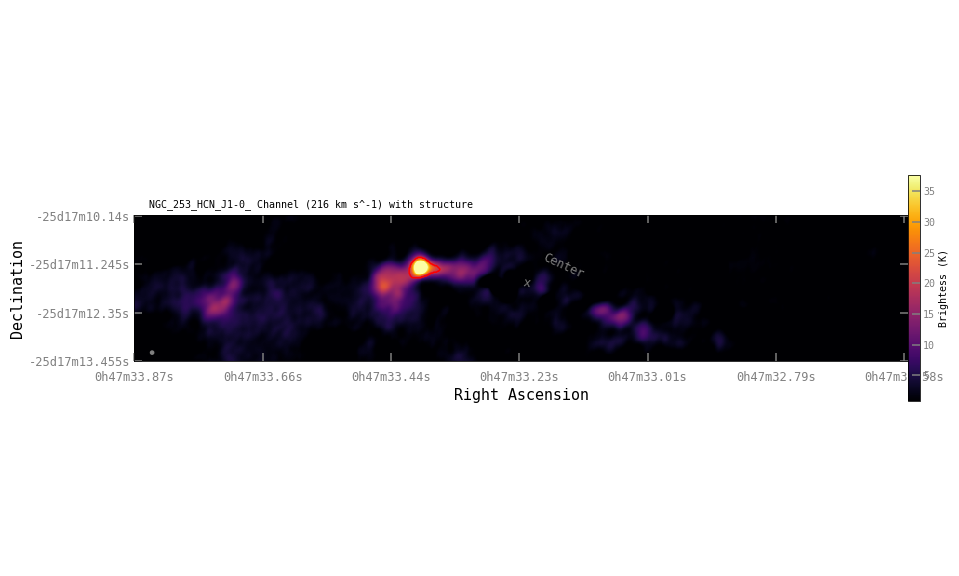

In [31]:
#testing cmz=coutours with lower vel range


"""CO 1-0 CMZ:
                        image_args={"FIX_AXIS":True,
                                   "FIGSIZE": (50,5),
                                   "COLORBARSCALE":.15,
                                   "SCALE":1,
                                   "XLABELS_NUM":58,
                                   "VMAX":550,
                                   "VMIN":-100,
                                   "SHOW":True,
                                   "DPI":800
                                  }
"""
        
image_args={
                                   "SCALE":1,
                                    "ChannelMapWidth": 25*u.km/u.s,
                                    "ChannelMapFIGSIZE": (40,20),
                                    "COLORBARSCALE":1.5,
                                    "XLABELS_NUM":6,
                                    "YLABELS_NUM":3
                                  }
dpi=600
fd = "NGC_253_HCN_J1-0_" # This changes between files based on the line description

with open("Spectral Cubes/Cube Information/"+fd+"_Cube_Information", 'rb') as file:

    Total = [ pickle.load(file)]
    
for Cube_Information in Total:
    
    Line_Name = Cube_Information['File_Descriptor']
    File_Name = Cube_Information['File_Name']
    distance = Cube_Information['distance']
    vel_prime = Cube_Information['velocity_scale']
    center = Cube_Information['center']
    Prime_Beam = (Cube_Information['beam_minor'].to(u.rad)*distance / u.rad).to(u.pc) #The current beam size in pc
    pathCont = Cube_Information["Corresponding_Continuum"]
    beam_area_ratio = Cube_Information['beam_area_ratio']
    
    noise_requirement = Cube_Information["Dendrogram_Noise_Threshold"]
    Minimum_Pixel_Requirement= Cube_Information["Minimum_Pixel_Requirement"] 
    min_delta=Cube_Information["min_delta"] 
    ###
    # Load statistics
    ###
    
    #with open("Result Files/"+"cmz_CO_J3_2_Testing_No_RepeatsCropped_3.0pc_beam_cmz_CO_J3_2_140.0x700.0pc_reprojected_2.5_vel_res__Results", 'rb') as file:
    with open("Result Files/"+fd+File_Name[0:len(File_Name)-5]+"_Results", 'rb') as file:
        Results = pickle.load(file)
        rads,v_rms,_3,_4,_5,idx,_7,_8,_9 = Results
    
    ###### 
    ### Make plots and contours
    ######
    
    Dend_Name= Cube_Information["Corresponding_Dendrogram"]
    Dendrogram = astrodendro.Dendrogram.load_from('Dendrograms/'+Dend_Name)

    # Load The SC
    
    Qp = SpectralCube.read("Spectral Cubes/"+File_Name).with_spectral_unit(u.km/u.s,velocity_convention="radio")
    Qp.allow_huge_operations=True

    Q = Qp.to(u.K)# Jy to Kelvin in case its not already in
    sc = Q.unmasked_copy() # remove a mask if there is one 
    del Q 
    del Qp

    # The cube data

    scW = sc.wcs[:][:][0]
    datn = sc.hdu.data
    moment_0_sc  = sc.moment(order=0,how='slice')            # Calculate the Moment 0 map to use for plotting
    header = sc.hdu.header
    
    #####
    #####
    # Reproject Continuum image to match the current image (this doesnt require any other data reduction steps since we already did those to the current SC)
    #####
    #####
    
    # Continuum image, for use in the column density maps
    
    scCont = spectral_cube.Projection.from_hdu(fits.open("Spectral Cubes/"+pathCont)) # {Why was there a  [0] here?}
    
    try:
        BUNIT = scCont.unit
        print("The continuum has unit",BUNIT)
        scCont = scCont.to(u.Jy/u.beam) #Fails if unitless
        BUNIT = scCont.unit
        print("Change to:",BUNIT)
        print("verify unit length is non zero, length = ",len(str(BUNIT)),str(BUNIT)) #Fails if there is no unit

    except:
        print("The continuum is unitless; unit defaults to Jy/beam")
        scCont = scCont*u.Jy/u.beam #Some data was taken before BUNIT were implemented, but they are in Jy/beam
        
    Use_Dict = {'desired_beam_oversampling': "NA"} # this is irrelevant since the continuum is higher resolution than the data cubes
    Use_Dict["distance"] = distance # same as for the data cube
    
    Continuum_Information = Update_Cube_Information(Use_Dict,pathCont)
    
    
    ## Reproject continuum 
    scCont.allow_huge_operations=True
    Continuum = scCont.reproject(moment_0_sc.header)
    del scCont
    Continuum_Data  = Continuum.hdu.data
    Cont_Save_File=(Continuum_Information["File_Name"][0:len(Continuum_Information["File_Name"])-5]+"_Reproject_to_"+Cube_Information['File_Descriptor']+".fits")
    
    # save the reprojected continuum     
    Continuum_Information = Update_Cube_Information(Continuum_Information,Cont_Save_File)
    
    # calculate the flux based on the beam to find te column density
    # flux = Jansky/beam/(pixels/beam)/(beam_physical_size in pc^2)*particle number density (using a factor to account for the other, non H2 particles in the 850um continuum)
    pc_per_pixel_continuum = Cube_Information['spatial_scale_y']

    # The flux, converting from Jy/beam, accounting for the beams physical size
    flux = (Continuum_Data*Continuum[0][0].unit)/((Continuum_Information["beam_area_ratio"]*(pc_per_pixel_continuum**2)).to(u.cm**2/u.beam))
    
    Column_Densities = Flux_to_Mass(flux,distance)*Num_per_kg  # Calculates the number-luminosity from the particle flux and converts it to mass using the conversion factor from Bolatto 2013a, in number/cm^2
    
    # Ratio of flux / column density (compare the continuum to teh line emission)
    rm=moment_0_sc.hdu.data/Column_Densities
    rmU = rm*moment_0_sc[0][0].unit # Just put the units back in
    del rm
    
    #rmU = np.array(rmU/10**22,dtype='float64')# reduce to floating point scale because they cant handle nubers this big

    ###### there are errors at low points, giving negative mass, so i exclude them if theyre below the noise

    bp = np.where(Column_Densities<=7*10**22/u.cm**2)
    bp2 = np.where(moment_0_sc.hdu.data < (np.nanstd(moment_0_sc.hdu.data,where= ((moment_0_sc.hdu.data>0)  | (moment_0_sc.hdu.data<0) )))) # below the Noise (K km/s)
    Continuum_Data_Cropped = copy.deepcopy(Continuum_Data)
    Continuum_Data_Cropped[bp] = np.nan # A version of the continuum data withuot the negative pixels
    
    Column_Densities_Cropped = copy.deepcopy(Column_Densities)
    Column_Densities_Cropped[bp]=np.nan # Remove negative pixels from the column densities
    
    rmU[bp]=np.nan # Remove the negative pixels from either the moment 0 or the continuum
    rmU[bp2]=np.nan

    #######

    m=Cube_Information["RMS_Noise"]
    
    print(m,"  RMS Noise for",Cube_Information["File_Descriptor"])
    
 





    ######
    ######
    ######
    ### Generate relevant plots before the dendrogram so we know what we're looking at
    ######
    ######
    ######
        
    #def Make_Image_Plot(Title,Cube,vmin,vmax,rows=1,columns=1,index=1,show=False):

    ###### Moment 0 and continuum plots


    #Make_Image_Plot((Line_Name+" Moment 0"),"Moment 0 Intensity (K km s^-1)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=0,vmax=np.nanmax(moment_0_sc.hdu.data),rows=1,columns=1,index=1,show=False,Cube_Info=Cube_Information,image_args=image_args)
    
    #pylab.show()
    '''
    Make_Image_Plot((Line_Name+" Moment 0 PC"),"Moment 0 Intensity (K km s^-1)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=0,vmax=np.nanmax(moment_0_sc.hdu.data),rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information,image_args=image_args)
    
    Center_p = moment_0_sc.wcs.world_to_pixel(center)
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()

    
    
    
    Make_Image_Plot((Line_Name+"Column Density"),"Column Density (# cm^-2)",Column_Densities,wcs=moment_0_sc.wcs,vmin=float(np.nanmin(Column_Densities.value)),vmax=float(np.nanmax(Column_Densities.value)),rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information) # Use the full line SC information here becasue I dont need specific things
    
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()


    Make_Image_Plot((Line_Name+" Moment 0 over Column Density of the Continuum"), "Ratio (K km s^-1 over (# cm^-2))",rmU.value,wcs=moment_0_sc.wcs,vmin=np.nanmean(rmU.value)*.5,vmax=abs(np.nanmean(rmU.value))*8,rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information)
    
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()

    '''  
    
    #def make_channel_maps(Title,Units,Cube_data,wcs,vmin,vmax,Axis="RADEC",Cube_Info='nil',image_args={},figsize=(13.33,8),numx=5,numy=5):

    moment_0_sc = sc[64]
    fig, ax ,im,cbar = Make_Image_Plot((Line_Name+" Channel (216 km s^-1) with structure"),"Brightness (K)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=np.nanmax(moment_0_sc.hdu.data)*.0131,vmax=np.nanmax(moment_0_sc.hdu.data)*.6,rows=1,columns=1,index=1,show=False,Axis="RADEC",Cube_Info=Cube_Information,image_args=image_args)
    
    Center_p = moment_0_sc.wcs.world_to_pixel(center)
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-25,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    

    ax.tick_params(axis='x', pad=10)

    p = Dendrogram.plotter() #dendrogram plotting object 
   
    
    ##############

    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_xlabel('')
    #ax.set_ylabel('')
    #plt.subplots_adjust(hspace=30)  # Increase vertical spacing
    #plt.subplots_adjust(wspace=0)  # Increase horizontal spacing


    p.plot_contour(ax, structure=36, lw=1, colors='red',alpha=1)
                
    l=idx[0].index(36)
    
    print(rads[0][l],v_rms[0][l],idx[0][l],_3[0][l],_4[0][l],_5[0][l],_7[0][l],_8[0][l],_9[0][l])


    cbar.set_label("Brightess (K)")


    #####################3
    plt.tight_layout(h_pad=-20.0,w_pad=12.01)
    
    #fig.savefig(("Plots/"+Line_Name+" Figure2"+".pdf"), dpi=dpi, bbox_inches='tight')
    #fig.savefig(("Plots/Pngs/"+Line_Name+" Figure2"+".png"), dpi=dpi, bbox_inches='tight')
    pylab.show()


The continuum has unit Jy / beam
Change to: Jy / beam
verify unit length is non zero, length =  9 Jy / beam
0.4407284600482864 K   RMS Noise for NGC_253_CO_J3-2_
(13.33, 8)
2.3512290341389632 pc 10.46512136174697 km / s 656 2.6720063236591014 km / s 2.7338006063522223e+29 erg / (Hz s) 2.1526215576403298e+27 1 / cm2 430617.2004086049 K km / s nan 0.0003889204144780184 pc


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
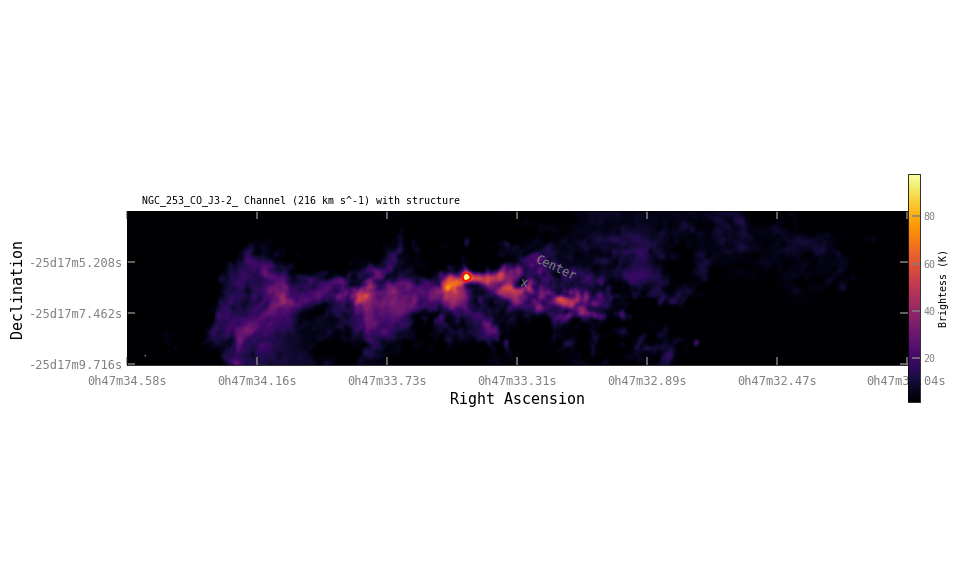

In [36]:
#testing cmz=coutours with lower vel range


"""CO 1-0 CMZ:
                        image_args={"FIX_AXIS":True,
                                   "FIGSIZE": (50,5),
                                   "COLORBARSCALE":.15,
                                   "SCALE":1,
                                   "XLABELS_NUM":58,
                                   "VMAX":550,
                                   "VMIN":-100,
                                   "SHOW":True,
                                   "DPI":800
                                  }
"""
        
image_args={
                                   "SCALE":1,
                                    "ChannelMapWidth": 25*u.km/u.s,
                                    "ChannelMapFIGSIZE": (40,20),
                                    "COLORBARSCALE":1.5,
                                    "XLABELS_NUM":6,
                                    "YLABELS_NUM":3
                                  }
dpi=600
fd = "NGC_253_CO_J3-2_" # This changes between files based on the line description

with open("Spectral Cubes/Cube Information/"+fd+"_Cube_Information", 'rb') as file:

    Total = [ pickle.load(file)]
    
for Cube_Information in Total:
    
    Line_Name = Cube_Information['File_Descriptor']
    File_Name = Cube_Information['File_Name']
    distance = Cube_Information['distance']
    vel_prime = Cube_Information['velocity_scale']
    center = Cube_Information['center']
    Prime_Beam = (Cube_Information['beam_minor'].to(u.rad)*distance / u.rad).to(u.pc) #The current beam size in pc
    pathCont = Cube_Information["Corresponding_Continuum"]
    beam_area_ratio = Cube_Information['beam_area_ratio']
    
    noise_requirement = Cube_Information["Dendrogram_Noise_Threshold"]
    Minimum_Pixel_Requirement= Cube_Information["Minimum_Pixel_Requirement"] 
    min_delta=Cube_Information["min_delta"] 
    ###
    # Load statistics
    ###
    
    #with open("Result Files/"+"cmz_CO_J3_2_Testing_No_RepeatsCropped_3.0pc_beam_cmz_CO_J3_2_140.0x700.0pc_reprojected_2.5_vel_res__Results", 'rb') as file:
    with open("Result Files/"+fd+File_Name[0:len(File_Name)-5]+"_Results", 'rb') as file:
        Results = pickle.load(file)
        rads,v_rms,_3,_4,_5,idx,_7,_8,_9 = Results
    
    ###### 
    ### Make plots and contours
    ######
    
    Dend_Name= Cube_Information["Corresponding_Dendrogram"]
    Dendrogram = astrodendro.Dendrogram.load_from('Dendrograms/'+Dend_Name)

    # Load The SC
    
    Qp = SpectralCube.read("Spectral Cubes/"+File_Name).with_spectral_unit(u.km/u.s,velocity_convention="radio")
    Qp.allow_huge_operations=True

    Q = Qp.to(u.K)# Jy to Kelvin in case its not already in
    sc = Q.unmasked_copy() # remove a mask if there is one 
    del Q 
    del Qp

    # The cube data

    scW = sc.wcs[:][:][0]
    datn = sc.hdu.data
    moment_0_sc  = sc.moment(order=0,how='slice')            # Calculate the Moment 0 map to use for plotting
    header = sc.hdu.header
    
    #####
    #####
    # Reproject Continuum image to match the current image (this doesnt require any other data reduction steps since we already did those to the current SC)
    #####
    #####
    
    # Continuum image, for use in the column density maps
    
    scCont = spectral_cube.Projection.from_hdu(fits.open("Spectral Cubes/"+pathCont)) # {Why was there a  [0] here?}
    
    try:
        BUNIT = scCont.unit
        print("The continuum has unit",BUNIT)
        scCont = scCont.to(u.Jy/u.beam) #Fails if unitless
        BUNIT = scCont.unit
        print("Change to:",BUNIT)
        print("verify unit length is non zero, length = ",len(str(BUNIT)),str(BUNIT)) #Fails if there is no unit

    except:
        print("The continuum is unitless; unit defaults to Jy/beam")
        scCont = scCont*u.Jy/u.beam #Some data was taken before BUNIT were implemented, but they are in Jy/beam
        
    Use_Dict = {'desired_beam_oversampling': "NA"} # this is irrelevant since the continuum is higher resolution than the data cubes
    Use_Dict["distance"] = distance # same as for the data cube
    
    Continuum_Information = Update_Cube_Information(Use_Dict,pathCont)
    
    
    ## Reproject continuum 
    scCont.allow_huge_operations=True
    Continuum = scCont.reproject(moment_0_sc.header)
    del scCont
    Continuum_Data  = Continuum.hdu.data
    Cont_Save_File=(Continuum_Information["File_Name"][0:len(Continuum_Information["File_Name"])-5]+"_Reproject_to_"+Cube_Information['File_Descriptor']+".fits")
    
    # save the reprojected continuum     
    Continuum_Information = Update_Cube_Information(Continuum_Information,Cont_Save_File)
    
    # calculate the flux based on the beam to find te column density
    # flux = Jansky/beam/(pixels/beam)/(beam_physical_size in pc^2)*particle number density (using a factor to account for the other, non H2 particles in the 850um continuum)
    pc_per_pixel_continuum = Cube_Information['spatial_scale_y']

    # The flux, converting from Jy/beam, accounting for the beams physical size
    flux = (Continuum_Data*Continuum[0][0].unit)/((Continuum_Information["beam_area_ratio"]*(pc_per_pixel_continuum**2)).to(u.cm**2/u.beam))
    
    Column_Densities = Flux_to_Mass(flux,distance)*Num_per_kg  # Calculates the number-luminosity from the particle flux and converts it to mass using the conversion factor from Bolatto 2013a, in number/cm^2
    
    # Ratio of flux / column density (compare the continuum to teh line emission)
    rm=moment_0_sc.hdu.data/Column_Densities
    rmU = rm*moment_0_sc[0][0].unit # Just put the units back in
    del rm
    
    #rmU = np.array(rmU/10**22,dtype='float64')# reduce to floating point scale because they cant handle nubers this big

    ###### there are errors at low points, giving negative mass, so i exclude them if theyre below the noise

    bp = np.where(Column_Densities<=7*10**22/u.cm**2)
    bp2 = np.where(moment_0_sc.hdu.data < (np.nanstd(moment_0_sc.hdu.data,where= ((moment_0_sc.hdu.data>0)  | (moment_0_sc.hdu.data<0) )))) # below the Noise (K km/s)
    Continuum_Data_Cropped = copy.deepcopy(Continuum_Data)
    Continuum_Data_Cropped[bp] = np.nan # A version of the continuum data withuot the negative pixels
    
    Column_Densities_Cropped = copy.deepcopy(Column_Densities)
    Column_Densities_Cropped[bp]=np.nan # Remove negative pixels from the column densities
    
    rmU[bp]=np.nan # Remove the negative pixels from either the moment 0 or the continuum
    rmU[bp2]=np.nan

    #######

    m=Cube_Information["RMS_Noise"]
    
    print(m,"  RMS Noise for",Cube_Information["File_Descriptor"])
    
 





    ######
    ######
    ######
    ### Generate relevant plots before the dendrogram so we know what we're looking at
    ######
    ######
    ######
        
    #def Make_Image_Plot(Title,Cube,vmin,vmax,rows=1,columns=1,index=1,show=False):

    ###### Moment 0 and continuum plots


    #Make_Image_Plot((Line_Name+" Moment 0"),"Moment 0 Intensity (K km s^-1)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=0,vmax=np.nanmax(moment_0_sc.hdu.data),rows=1,columns=1,index=1,show=False,Cube_Info=Cube_Information,image_args=image_args)
    
    #pylab.show()
    '''
    Make_Image_Plot((Line_Name+" Moment 0 PC"),"Moment 0 Intensity (K km s^-1)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=0,vmax=np.nanmax(moment_0_sc.hdu.data),rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information,image_args=image_args)
    
    Center_p = moment_0_sc.wcs.world_to_pixel(center)
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()

    
    
    
    Make_Image_Plot((Line_Name+"Column Density"),"Column Density (# cm^-2)",Column_Densities,wcs=moment_0_sc.wcs,vmin=float(np.nanmin(Column_Densities.value)),vmax=float(np.nanmax(Column_Densities.value)),rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information) # Use the full line SC information here becasue I dont need specific things
    
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()


    Make_Image_Plot((Line_Name+" Moment 0 over Column Density of the Continuum"), "Ratio (K km s^-1 over (# cm^-2))",rmU.value,wcs=moment_0_sc.wcs,vmin=np.nanmean(rmU.value)*.5,vmax=abs(np.nanmean(rmU.value))*8,rows=1,columns=1,index=1,show=False,Axis="PC",Cube_Info=Cube_Information)
    
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-20,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    
    pylab.show()

    '''  
    
    #def make_channel_maps(Title,Units,Cube_data,wcs,vmin,vmax,Axis="RADEC",Cube_Info='nil',image_args={},figsize=(13.33,8),numx=5,numy=5):

    moment_0_sc = sc[80]
    fig, ax ,im,cbar = Make_Image_Plot((Line_Name+" Channel (216 km s^-1) with structure"),"Brightness (K)",moment_0_sc.hdu.data,wcs=moment_0_sc.wcs,vmin=np.nanmax(moment_0_sc.hdu.data)*.0131,vmax=np.nanmax(moment_0_sc.hdu.data)*.9,rows=1,columns=1,index=1,show=False,Axis="RADEC",Cube_Info=Cube_Information,image_args=image_args)
    
    Center_p = moment_0_sc.wcs.world_to_pixel(center)
    pylab.annotate(text="Center",fontsize=12,xy=(Center_p[0]+20, Center_p[1]+10), rotation=-25,color="gray")  
    pylab.annotate(text="x",fontsize=12,xy=(Center_p[0], Center_p[1]), rotation=-10,color="gray")  
    

    ax.tick_params(axis='x', pad=10)

    p = Dendrogram.plotter() #dendrogram plotting object 
   
    
    ##############

    #ax.set_xticks([])
    #ax.set_yticks([])
    #ax.set_xlabel('')
    #ax.set_ylabel('')
    #plt.subplots_adjust(hspace=30)  # Increase vertical spacing
    #plt.subplots_adjust(wspace=0)  # Increase horizontal spacing


    p.plot_contour(ax, structure=656, lw=1, colors='red',alpha=1)
                
    l=idx[0].index(656)
    
    print(rads[0][l],v_rms[0][l],idx[0][l],_3[0][l],_4[0][l],_5[0][l],_7[0][l],_8[0][l],_9[0][l])


    cbar.set_label("Brightess (K)")


    #####################3
    plt.tight_layout(h_pad=-20.0,w_pad=12.01)
    
    #fig.savefig(("Plots/"+Line_Name+" Figure2"+".pdf"), dpi=dpi, bbox_inches='tight')
    #fig.savefig(("Plots/Pngs/"+Line_Name+" Figure2"+".png"), dpi=dpi, bbox_inches='tight')
    pylab.show()
